<a href="https://colab.research.google.com/github/willjhliang/traffic-sign-recognition/blob/main/Submission_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition Walkthrough
This notebook first explains how we visualized and processed our traffic sign dataset, then dives into our Convolutional Neural Network training, evlauation, and visualization process.

**Content Creators:** Yifei (Freddy) Liu, William Liang, Vincent Cai

# Setup
First, we download the dataset from github and import relevant libraries. To save time in this notebook, we also saved a trained version of our CNN and load it in as well. 

In [1]:
!git clone --quiet https://github.com/willjhliang/traffic-sign-recognition.git
!mv traffic-sign-recognition/* .
!rm -r traffic-sign-recognition

In [3]:
from copy import deepcopy
import itertools

import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import itertools
import random
from heapq import heappush, heappop

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (4, 2.5)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from tabulate import tabulate
import seaborn as sns

import torch
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils import data
import torchvision

In [4]:
K = 36                   # Number of total classes
S = 32                   # Size of image, dimension is (S, S, 3)
class_size = 320         # Number of images per class
validation_ratio = 0.1   # Proportion of training data to set aside for validation

random_seed = 19104    
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed);

# Dataset
Below are functions that load the dataset from the downloaded files and visualize the class distribution.

In [5]:
def load_data(datapath):
    """Loads images from files and performs basic pre-processing."""
    data = {}
    for k in range(K):
        data[k] = []

    for f in os.listdir(datapath):
        k = int(f[:3])  # Get label from filename
        img = Image.open(os.path.join(datapath, f)).convert('RGB')
        img = np.asarray(img) / 255  # Set pixel values to [0, 1]
        if len(data[k]) < class_size:
            data[k].append(img)
    for k in range(K):
        random.shuffle(data[k])
    
    return data


def visualize_data(train_data):
    """Visualizes the first image in each class."""
    _, axs = plt.subplots(4, 10, figsize=(10, 3))
    for k, (i, j) in itertools.zip_longest(range(K), list(itertools.product(range(4), range(10))), fillvalue=-1):
        axs[i, j].axis('off')
        if k >= 0:
            axs[i,j].imshow(train_data[k][0])


def compare_class_dist(data_1, data_2):
    """Compares the class distribution of two datasets."""
    class_dist_1 = [len(data_1[k]) for k in range(K)]
    class_dist_2 = [len(data_2[k]) for k in range(K)]

    _, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    axs[0].bar(list(range(K)), class_dist_1)
    axs[1].bar(list(range(K)), class_dist_2);

In [6]:
train_data = load_data('data/filtered_images/train')
test_data = load_data('data/filtered_images/test')
labels = pd.read_csv("data/filtered_labels.csv")

Run the cell below to look at the first image in each of the 36 classes. It also plots the class distributions for both the training (left) and test (right) sets.

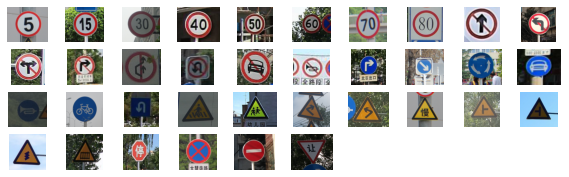

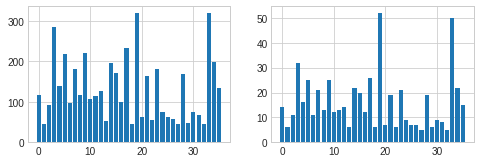

In [7]:
visualize_data(train_data)
compare_class_dist(train_data, test_data)

It looks like there is a significant amount of class imbalance here. We will use image augmentation techniques to generate more training images and even out the distribution.

## Pre-Processing
We define the center crop, rotation, and brightness shift augmentation methods below. However, as discussed in our paper, we only use the rotation function to generate augmented images.

In [8]:
def center_crop(img, center_percentage):
    """Crops out edges of an image, leaving the center."""
    width, height, _ = img.shape
    width_offset = int(width * (1 - center_percentage) / 2)
    height_offset = int(height * (1 - center_percentage) / 2)
    img = img[width_offset:width-width_offset, height_offset:height-height_offset]
    return img


def rotate_img(img, angle):
    """Rotates an image and replaces empty space with black."""
    height, width, _ = img.shape
    center_x, center_y = (width // 2, height // 2)

    rot_mat = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])

    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    rot_mat[0, 2] += (new_width / 2) - center_x
    rot_mat[1, 2] += (new_height / 2) - center_y

    img = cv2.warpAffine(img, rot_mat, (new_width, new_height))
    img = cv2.resize(img, (width, height))

    return img


def shift_brightness(img, shift):
    """Adjusts brightness of all pixels in image."""
    img = np.clip(img + shift, 0, 1)
    return img


def augment_img(img):
    """Augments image with rotation, cropping, and brightness shifts."""
    rot_angle = random.randint(-20, 20)
    crop_center_percentage = random.randint(70, 90) / 100
    crop_center_percentage = 0.8
    brightness_shift = random.randint(-10, 10) / 100

    img = rotate_img(img, rot_angle)
    img = center_crop(img, 0.8)

    return img


def augment_dataset(train_data):
    """Applies augmentation to all classes in dataset."""
    max_k_size = max([len(train_data[k]) for k in range(len(train_data))])
    for k in range(len(train_data)):
        k_size = len(train_data[k])
        for i in range(max_k_size - k_size):  # Add augmented images until we have class_size images
            train_data[k].append(augment_img(train_data[k][i % k_size]))
    return train_data


def visualize_augmentation(train_data):
    """Visualizes the augmentation applied onto the last image in each class."""
    fig, axs = plt.subplots(4, 10, figsize=(15, 5))
    for k, (i, j) in itertools.zip_longest(range(len(train_data)), list(itertools.product(range(4), range(10))), fillvalue=-1):
        axs[i,j].axis('off')
        if k >= 0:
            img = augment_img(train_data[k][-1])
            axs[i,j].imshow(augment_img(img))
    plt.show()

Run the cell below to augment the data. We can compare the class distributions of our original train set and our new train set after the image augmentations; the new distribution now has the same number of images per class.

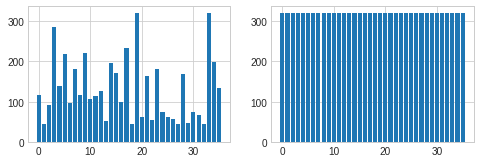

In [9]:
original_train_data = deepcopy(train_data)
train_data = augment_dataset(train_data)
compare_class_dist(original_train_data, train_data)

Finally, we convert our dictionary of images into a numpy arrays for training and testing.

In [10]:
def consolidate_data(data):
    """Converts image-label data from map to numpy arrays."""
    X = []
    y = []
    for k in range(K):
        for i in data[k]:
            i = cv2.resize(i, (S, S))
            X.append(np.swapaxes(i, 0, -1))
            y.append(k)
    X = np.array(X)
    y = np.array(y)
    
    shuffled_indices = np.random.permutation(len(X))
    X = X[shuffled_indices]
    y = y[shuffled_indices]
    X_flattened = np.reshape(X, (X.shape[0], -1))
    
    return X, X_flattened, y

def split_validation(X_train, y_train):
    """Splits training data into train and validation sets. Used in models below."""
    val_split = int(X_train.shape[0] * validation_ratio)
    X_train, X_val = X_train[val_split:], X_train[:val_split]
    y_train, y_val = y_train[val_split:], y_train[:val_split]
    return X_train, X_val, y_train, y_val

In [11]:
X_train, X_train_flattened, y_train = consolidate_data(train_data)
X_test, X_test_flattened, y_test = consolidate_data(test_data)

print(f'X_train shape: {X_train.shape}')
print(f'X_train_flattened shape: {X_train_flattened.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (11520, 3, 32, 32)
X_train_flattened shape: (11520, 3072)
X_test shape: (572, 3, 32, 32)


## Dimensionality Reduction
Though our CNN doesn't use PCA, a visualization of the principal components is still informative of the variance of information and kinds of information present in our dataset.

We first chart variance explained by the top principal components and find that 150 components explains most of the information in our data. We then visualize the top 24 components and project a sample image onto the top component, then the top two, and so on, observing that the image gradually looks more and more like the original.

In [12]:
def run_pca(X_train_flattened, X_test_flattened):
    """Runs PCA on training and test data, visualizing the variance explained by each component."""
    covar_matrix = PCA(n_components=min(X_train_flattened.shape[0], 32*32))
    covar_matrix.fit(X_train_flattened)
    var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
    plt.plot(var[:300]);

    pca = PCA(n_components=150)
    pca.fit(X_train_flattened)
    X_train_pca = pca.transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)
    return X_train_pca, X_test_pca, pca


def visualize_pca(pca):
    """Visualizes first 24 principal components."""
    fig, axes = plt.subplots(3, 8, figsize=(9, 3.5),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1)
    )
    
    for i, ax in enumerate(axes.flat):
        img = pca.components_[i].reshape(3, 32, 32)
        min_val, max_val = np.min(img), np.max(img)
        img = (img - min_val) / (max_val - min_val)
        img = np.swapaxes(img, 0, -1)
        ax.imshow(img)
    plt.show()


def visualize_image_components(pca, image):
   fig, axes = plt.subplots(1, 8, figsize=(9, 3),
       subplot_kw={'xticks':[], 'yticks':[]},
       gridspec_kw=dict(hspace=0.1, wspace=0.1)
   )
  
   ns = [0, 1, 2, 10, 30, 50, 100, 150]
   for i, ax in enumerate(axes.flat):
       if i >= len(ns): break
       img = pca.components_[:ns[i] + 1] @ image @ pca.components_[:ns[i] + 1]
       min_val, max_val = np.min(img), np.max(img)
       img = (img - min_val) / (max_val - min_val)
       img = img.reshape(3, 32, 32)
       img = np.swapaxes(img, 0, -1)
       ax.imshow(img)

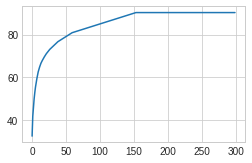

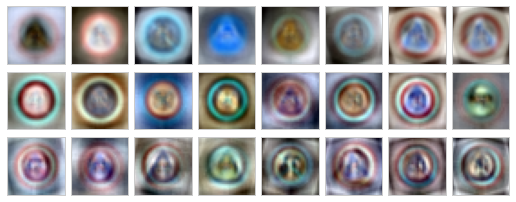

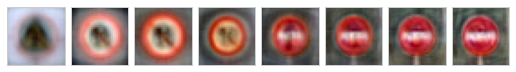

In [13]:
X_train_pca, X_test_pca, pca = run_pca(X_train_flattened, X_test_flattened)
visualize_pca(pca)
visualize_image_components(pca, X_train_flattened[1])

In the top graph we have a plot of variance explained against number of principal components used. We see a leveling off at around 150 principal components, which is what we end up choosing for our dimensionality reduction.

In the first three rows we visualize the first 24 principal components in order of variance explained, from top left to bottom right.

In the last row we can see what happens when we project an image on to the 0, 1, 2, 10, 30, 50, 100, 150 principle components (including the ones before it).

# Model
Now we will first take a look at the different CNN model architectures that we evaluated. There is no need to train a model on all of these as it will take a long time. For this notebook's purposes, we only need the Large CNN architecture; the rest demonstrate the other CNN architectures we evaluated.

In [14]:
# Large CNN
class CNN_L(nn.Module):
    def __init__(self):
        super(CNN_L, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.dropout_3 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_3(x)
        x = self.linear_2(x)
        return x

## Other CNN Architectures

In [18]:
# Extra Small CNN
class CNN_XS(nn.Module):
    def __init__(self):
        super(CNN_XS, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 32, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.max_pool2d(x)
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [19]:
# Small CNN
class CNN_S(nn.Module):
    def __init__(self):
        super(CNN_S, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(16 * 16 * 32, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [20]:
# Medium CNN
class CNN_M(nn.Module):
    def __init__(self):
        super(CNN_M, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 64, 128)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [24]:
# Large CNN without dropout
class CNN_L_NoDropout(nn.Module):
    def __init__(self):
        super(CNN_L_NoDropout, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [25]:
# Large CNN without batch norm
class CNN_L_NoBatchNorm(nn.Module):
    def __init__(self):
        super(CNN_L_NoBatchNorm, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout_2 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(4 * 4 * 64, 128)
        self.dropout_3 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.max_pool2d(x)

        x = self.relu(self.conv_3(x))
        x = self.relu(self.conv_4(x))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_3(x)
        x = self.linear_2(x)
        return x

In [26]:
# Extra Large CNN
class CNN_XL(nn.Module):
    def __init__(self):
        super(CNN_XL, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_6 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout(0.5)

        self.conv_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_7 = nn.BatchNorm2d(64)
        self.conv_8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_8 = nn.BatchNorm2d(64)
        self.dropout_3 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(2 * 2 * 64, 128)
        self.dropout_4 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_5(self.conv_5(x)))
        x = self.relu(self.batch_norm_6(self.conv_6(x)))
        x = self.dropout_2(x)
        x = self.max_pool2d(x)
        
        x = self.relu(self.batch_norm_7(self.conv_7(x)))
        x = self.relu(self.batch_norm_8(self.conv_8(x)))
        x = self.dropout_3(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_4(x)
        x = self.linear_2(x)
        return x

# Training
Below, we define methods that will be used to train the CNN model.

In [15]:
def load_torch_data(X_train, y_train, X_test, y_test):
    """Converts numpy data to torch dataloaders."""
    X_train, X_val, y_train, y_val = split_validation(X_train, y_train)
    train_set = data.TensorDataset(Tensor(X_train), Tensor(y_train))
    val_set = data.TensorDataset(Tensor(X_val), Tensor(y_val))
    test_set = data.TensorDataset(Tensor(X_test), Tensor(y_test))
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=32, shuffle=True)
    return train_loader, val_loader, test_loader
    

def train_model(model, train_loader, val_loader, epochs, lr):
    """Trains model and plots loss and accuracies."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) 

    losses = []
    train_accuracy, val_accuracy = [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_f1, val_f1 = [], []
    for epoch in range(epochs):
        running_loss = 0
        for itr, (image, label) in enumerate(train_loader):
            optimizer.zero_grad()
            y_predicted = model(image)
            label = label.long()

            loss = criterion(y_predicted, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
    
        losses.append(running_loss)
        _, (accuracy, precision, recall, f1) = evaluate_model(model, train_loader)
        train_accuracy.append(accuracy)
        train_precision.append(precision)
        train_recall.append(recall)
        train_f1.append(f1)
        _, (accuracy, precision, recall, f1) = evaluate_model(model, val_loader)
        val_accuracy.append(accuracy)
        val_precision.append(precision)
        val_recall.append(recall)
        val_f1.append(f1)
        print(f'Epoch: {epoch+1:03}, Loss: {running_loss:9.4f}, Train F1: {train_f1[-1]:.4f}, Validation F1: {val_f1[-1]:.4f}')

    fig, axs = plt.subplots(1, 5, figsize=(20, 2.5))
    axs[0].plot(losses)
    axs[1].plot(list(range(epochs)), train_accuracy, val_accuracy);
    axs[2].plot(list(range(epochs)), train_precision, val_precision);
    axs[3].plot(list(range(epochs)), train_recall, val_recall);
    axs[4].plot(list(range(epochs)), train_f1, val_f1);

    return model


def evaluate_model(model, dataloader):
    """Evaluates model and returns predictions, truth labels, and metrics."""
    accuracy, precision, recall, f1 = 0, 0, 0, 0

    preds = torch.Tensor([])
    labels = torch.Tensor([])
    with torch.no_grad():
        for _, (images, batch_labels) in enumerate(dataloader):
            outputs = model(images)
            _, batch_preds = torch.max(outputs.data, 1)
            preds = torch.cat((preds, batch_preds))
            labels = torch.cat((labels, batch_labels))
            batch_weight = images.size(0) / len(dataloader.dataset)
            accuracy += batch_weight * accuracy_score(batch_labels, batch_preds)
            precision += batch_weight * precision_score(batch_labels, batch_preds, average='macro', zero_division=0)
            recall += batch_weight * recall_score(batch_labels, batch_preds, average='macro', zero_division=0)
            f1 += batch_weight * f1_score(batch_labels, batch_preds, average='macro', zero_division=0)

    return (preds.tolist(), labels.tolist()), (accuracy, precision, recall, f1)

The cell below trains the CNN on our dataset. You may run this if you want to see the exact the training and validation F1 scores for the various epochs, but it takes a while to train. We included the second cell below to directly load trained weights from a file downloaded earlier. An example output of our training process is as follows. The charts are loss, accuracy, precision, recall, and macro F1, in that order.


```
Epoch: 001, Loss:  597.8488, Train F1: 0.6585, Validation F1: 0.6399
Epoch: 002, Loss:  174.6411, Train F1: 0.8257, Validation F1: 0.8162
Epoch: 003, Loss:   78.8031, Train F1: 0.9205, Validation F1: 0.9172
Epoch: 004, Loss:   47.1207, Train F1: 0.9512, Validation F1: 0.9504
Epoch: 005, Loss:   27.2004, Train F1: 0.9673, Validation F1: 0.9528
Epoch: 006, Loss:   24.0346, Train F1: 0.9666, Validation F1: 0.9592
Epoch: 007, Loss:   21.4762, Train F1: 0.9698, Validation F1: 0.9609
Epoch: 008, Loss:   19.4115, Train F1: 0.9638, Validation F1: 0.9499
Epoch: 009, Loss:   15.8748, Train F1: 0.9729, Validation F1: 0.9469
Epoch: 010, Loss:   14.7798, Train F1: 0.9642, Validation F1: 0.9542
```
![](https://www.kaggleusercontent.com/kf/113413086/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..5YMnhwKrboDE9OWQPZTqgg.3v1qnp7lS7FXcA_vzyQkrxL3nC__k2i0FdlLGeK9NJFd_dO1VaJFfLnou-8cCopIycZOhvq14qnOO7g-lijl0OTSH2tEzzUcN-lixFRbCS--x3FqzFhN91DRd7D6BkscX2BSaHzmbUwy3B3Jr2srgMHSumSUOtgAYKH6O-p2rn0LKadz4Iq_FlQY9-C5cGx4Bt5EiM-k3ked5l3fNWqFFcnfuugbJ2CcLm3nnIuJOIogKKdnUs6V9Xr4qGLtfbgQzMY9zLQhqMxlkyudNl9-bJ97Ly83yUWyy7gc7R19VJhOH9fvxhZCbBWi0m-bLrcwsZXbNQku2TVBD_tuQeNMqPCrA0DTqajnaXg6cYg575XZWqv5UO3dTENrZ9g83gXhg3ONqN-kJlY_fW4h24g6XGBAuMcudj_Tg8vr1Jt3iHwMCmsFtN5QO8WEQOKl0pCF_e647ZmhY6aGV1A-JjjTXPkANJ86WG2Pgr4aomn-VxEHCF7O75nOfCzykET2xy64CW66nBvUeS3SzlBAhf4VEHK4Vt2wE83JEyHxSdlaiQ5n-uyfKDvwiDgF4ikYnPEQw9fKe2PjrbFFN4wACYZ-eBwWz7-Ks5F-vYjwxewvaPMGpxXR7ul9mG8yFVhvPzBdGO8EtjKhnm2nYRR_1_524X40kwOHMjUyrbY8CjWPdjk.0UVCIqbPUrxIOkc_IsPQrA/__results___files/__results___1_4.png)


Epoch: 001, Loss:  553.5249, Train F1: 0.6782, Validation F1: 0.6622
Epoch: 002, Loss:  156.8301, Train F1: 0.8401, Validation F1: 0.8322
Epoch: 003, Loss:   69.1054, Train F1: 0.9418, Validation F1: 0.9221
Epoch: 004, Loss:   38.7077, Train F1: 0.9569, Validation F1: 0.9361
Epoch: 005, Loss:   28.5867, Train F1: 0.9718, Validation F1: 0.9377
Epoch: 006, Loss:   26.0522, Train F1: 0.9610, Validation F1: 0.9248
Epoch: 007, Loss:   22.9230, Train F1: 0.9742, Validation F1: 0.9636
Epoch: 008, Loss:   19.7080, Train F1: 0.9345, Validation F1: 0.9064
Epoch: 009, Loss:   18.1093, Train F1: 0.9645, Validation F1: 0.9356
Epoch: 010, Loss:   15.0453, Train F1: 0.9653, Validation F1: 0.9499


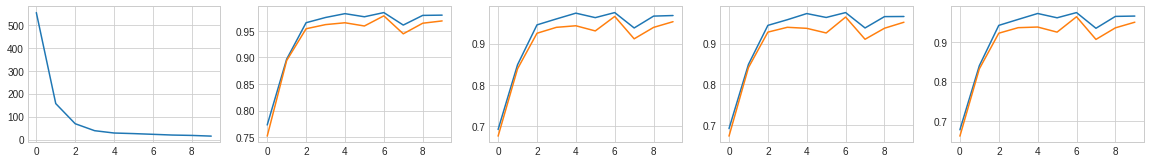

In [25]:
# Caution: this cell took around 10 minutes on a GPU Colab instance to complete.

train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_L(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [17]:
model = CNN_L()
model.load_state_dict(torch.load('saves/modelstate'))
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

# Evaluation

Below are methods used to evaluate the model. We initially generated confusion matrices, but given the model's strong performance, there were barely anything outside of the diagonal. The two other methods compute overall and class-wise metrics and plot the F1 scores of each class.

In [26]:
def generate_confusion_matrix(y_actual, y_pred, labels):
    """Generates a confusion matrix for the given labels and predictions."""
    mat = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize = (30, 30))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = labels['Name'], yticklabels = labels['Name'])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
 
 
def get_classification_report(y_actual, y_pred, labels, print_df=False):
    """Reports evaluation metrics for the given labels and predictions."""
    report = classification_report(y_actual, y_pred, target_names = labels['Name'], output_dict = True, zero_division=0)
    mat = confusion_matrix(y_actual, y_pred)
    class_accuracies = mat.diagonal()/(mat.sum(axis = 1))
    for index, class_name in enumerate(labels['Name']):
        report[class_name]['accuracy'] = class_accuracies[index]

    df = pd.DataFrame.from_dict(report).T
    if print_df:
        print(tabulate(df, headers = ['Label', 'Precision', 'Recall', 'F1 Score', 'Support', 'Accuracy'], tablefmt = 'simple_grid'))

    metrics = ['macro avg', 'weighted avg']
    headers = list(report[metrics[0]].keys())
    table = [[metric] + list(report[metric].values()) for metric in metrics]
    print(f'accuracy: {report["accuracy"]}')
    print(tabulate(table, headers=headers, tablefmt='simple_grid'))

    return report, df


def generate_class_comparison(report, metric, labels):
    """Compares metrics for each class."""
    classes = list(labels['Name'])
    values = [report[cls][metric] for cls in classes]
    plt.xticks([], [])
    plt.bar(classes, values)
    plt.show()

accuracy: 0.9825174825174825
                precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
macro avg        0.977637  0.978235    0.97592         572
weighted avg     0.983784  0.982517    0.982255        572


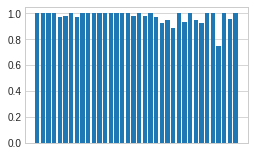

In [27]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)

# Visualization

The F1 scores are extremely high, and we were curious about the inner workings of the CNN. Below are three methods we used for explainability.
1. The first gets the top 8 images that had the highest activations for certain neurons in the final layer.
2. The second plots 200 images based on their activations projected onto 2D space.
3. The third runs the CNN through adversarial attacks and plots the images it got wrong.

Note that these results will be different from the ones in our paper since we're not using the same exact model weights.

In [21]:
def visualize_top_activations(model, X_train):
    """Visualizes images that have highest activations in certain neurons after last convolutional layer."""
    indices = [0, 8, 24]
    activations = [[] for _ in range(len(indices))]

    for i in range(X_train.shape[0]):
        img = X_train[i]
        x = torch.from_numpy(np.expand_dims(X_train[i].astype(np.float32), 0))
        x = model.relu(model.batch_norm_1(model.conv_1(x)))
        x = model.relu(model.batch_norm_2(model.conv_2(x)))
        x = model.max_pool2d(x)
        x = model.relu(model.batch_norm_3(model.conv_3(x)))
        x = model.relu(model.batch_norm_4(model.conv_4(x)))
        x = model.dropout_1(x)
        x = model.max_pool2d(x)
        x = model.relu(model.batch_norm_5(model.conv_5(x)))
        x = model.relu(model.batch_norm_6(model.conv_6(x)))
        x = model.dropout_2(x)
        x = model.max_pool2d(x)
        for j, idx in enumerate(indices):
            heappush(activations[j], (x[0, idx, 0, 0].item(), i))
            if len(activations[j]) > 8:
                heappop(activations[j])
    
    print(f'--- Top activations for final convolutional layer index {indices} ---')
    _, axs = plt.subplots(len(indices), 8, figsize=(8, 1.5*len(indices)))
    for j in range(len(indices)):
        for i in range(8):
            axs[j, i].axis('off')
            img = X_train[heappop(activations[j])[1]]
            axs[j, i].imshow(np.swapaxes(img, 0, -1))


def visualize_tsne_similarity(model, X_train):
    """Visualizes image similarity measured by activations after last convolutional layer."""
    features = []
    with torch.no_grad():
        for i in range(200):
            img = X_train[i]
            x = torch.from_numpy(np.expand_dims(X_train[i].astype(np.float32), 0))
            x = model.relu(model.batch_norm_1(model.conv_1(x)))
            x = model.relu(model.batch_norm_2(model.conv_2(x)))
            x = model.max_pool2d(x)
            x = model.relu(model.batch_norm_3(model.conv_3(x)))
            x = model.relu(model.batch_norm_4(model.conv_4(x)))
            x = model.dropout_1(x)
            x = model.max_pool2d(x)
            x = model.relu(model.batch_norm_5(model.conv_5(x)))
            x = model.relu(model.batch_norm_6(model.conv_6(x)))
            x = model.dropout_2(x)
            x = model.max_pool2d(x)
            features.append(x.numpy().flatten())
    
    tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(features)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 2000
    height = 2000
    max_dim = 100

    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(X_train, tx, ty):
        tile = Image.fromarray((np.swapaxes(img, 0, -1) * 255).astype(np.uint8)).resize((224, 224))
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    print('--- Image similarity measured by final convolutional activations ---')
    plt.figure(figsize = (16,12))
    plt.imshow(full_image)


def adversarial_attack(model, labels):
    """Tests model against adversarial images, visualizing mispredictions."""
    adversarial_data = load_data('data/adversarial_images')
    X_adv, _, y_adv = consolidate_data(adversarial_data)
    failed = []
    for i in range(X_adv.shape[0]):
        out = model(torch.from_numpy(np.expand_dims(X_adv[i], 0).astype(np.float32)))
        _, pred = torch.max(out.data, 1)
        if pred != y_adv[i]:
            failed.append((i, pred.item()))
    failed = failed[:8]

    print('--- Failed adversarial examples ---')
    _, axs = plt.subplots(1, len(failed), figsize=(len(failed) * 2.5, 1.5))
    for i, (img_idx, pred) in enumerate(failed):
        axs[i].axis('off')
        img = X_adv[img_idx]
        axs[i].imshow(np.swapaxes(img, 0, -1))
        axs[i].title.set_text(labels['Name'][pred])

--- Top activations for final convolutional layer index [0, 8, 24] ---


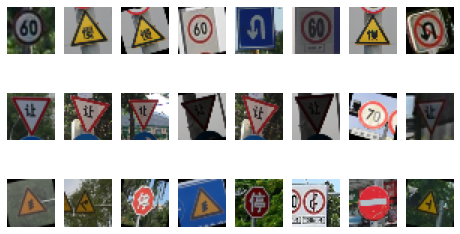

In [22]:
visualize_top_activations(model, X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 20.879981
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 61.0911179, gradient norm = 0.5807416 (50 iterations in 0.104s)
[t-SNE] Iteration 100: error = 61.3511200, gradient norm = 0.5929329 (50 iterations in 0.067s)
[t-SNE] Iteration 150: error = 60.2175674, gradient norm = 0.5983253 (50 iterations in 0.063s)
[t-SNE] Iteration 200: error = 61.2639008, gradient norm = 0.5904506 (50 iterations in 0.066s)
[t-SNE] Iteration 250: error = 59.6891556, gradient norm = 0.6277812 (50 iterations in 0.061s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.689156
[t-SNE] Iteration 300: error = 0.5950037, gradient norm = 0.0051824 (50 iterations in 0.060s)
[t-SNE] Iteration 350: error = 0.5111508, gradient norm = 0.0009194 

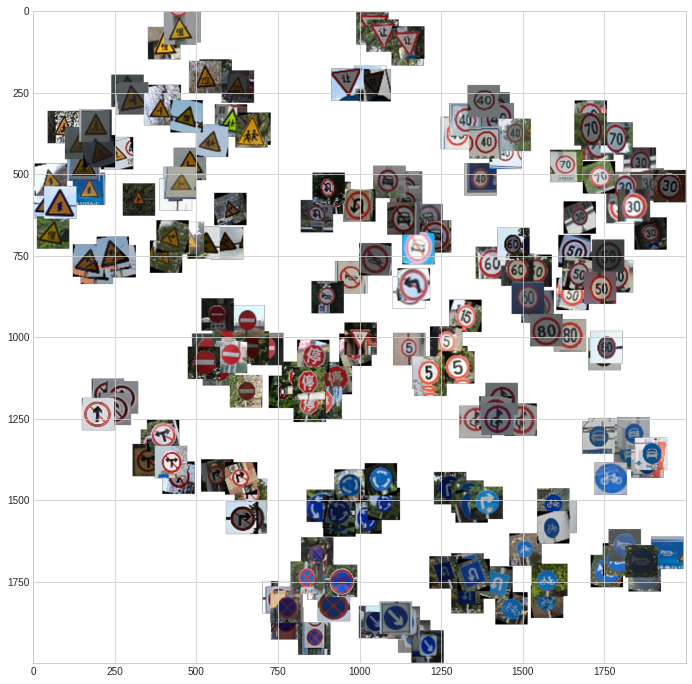

In [23]:
visualize_tsne_similarity(model, X_train)

--- Failed adversarial examples ---


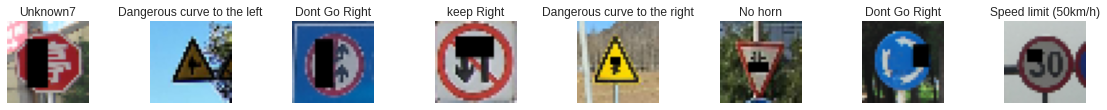

In [24]:
adversarial_attack(model, labels)